Nengo output and NEF output for LIF neuron matches (including voltage output - threshold 1 and reset at 0 and spike output). One needs to filter the NEF output spikes with the synaptic filter first and then decode it using the Decoder matrix obtained from the filtered spike activity matrix, i.e.

## Filter spikes -> Decode filtered spikes

In [1]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
SEED = 0

# Simulate a Nengo Model for Cos curve

In [7]:
model = nengo.Network(label="A Single Neuron")
with model:
    neuron = nengo.Ensemble(
        1,
        dimensions=1,  # Represent a scalar
        # Set intercept to 0.5, Radius is 1 by default.
        intercepts=nengo.dists.Uniform(-0.5, -0.5),
        # Set the maximum firing rate of the neuron to 100hz
        max_rates=nengo.dists.Uniform(100, 100),
        # Set the neuron's firing rate to increase for positive input
        encoders=[[1]],
    )

In [8]:
with model:
    cos = nengo.Node(lambda t: np.cos(8 * t))
    #cos = nengo.Node(0) # Input a constant value i.e. x=0 and x=1 here to determine the Nengo LIF neuron firing rate.
with model:
    # Connect the input signal to the neuron
    conn = nengo.Connection(cos, neuron)
    #conn2 = nengo.Connection(neuron, neuron)
with model:
    # The original input
    cos_probe = nengo.Probe(cos)
    # The raw spikes from the neuron, the spikes are of amplitude 1/dt
    spikes = nengo.Probe(neuron.neurons)
    # Subthreshold soma voltage of the neuron
    voltage = nengo.Probe(neuron.neurons, "voltage")
    # Spikes filtered by a 10ms post-synaptic filter
    filtered = nengo.Probe(neuron, synapse=0.010)


In [9]:
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(1)  # Run it for 1 second


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(0.0, 1.0)

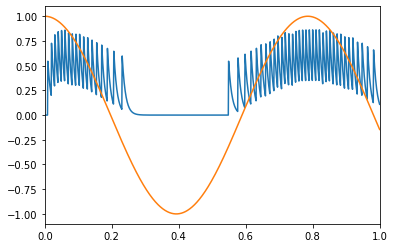

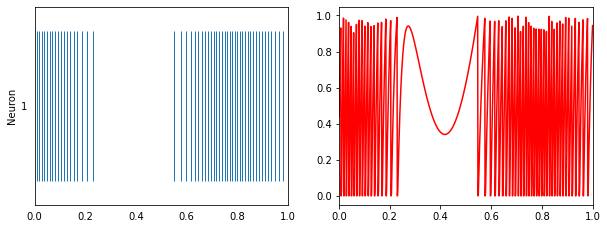

In [10]:
from nengo.utils.matplotlib import rasterplot
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[filtered])
plt.plot(sim.trange(), sim.data[cos_probe])
plt.xlim(0, 1)

# Plot the spiking output of the ensemble
plt.figure(figsize=(10, 8))
plt.subplot(221)
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlim(0, 1)

# Plot the soma voltages of the neurons
plt.subplot(222)
plt.plot(sim.trange(), sim.data[voltage][:, 0], "r")
plt.xlim(0, 1)

## Print Spikes

In [11]:
print(sim.data[spikes].tolist()[:100]) # Spikes are of amplitude 1/dt.

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1000.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


## Low Pass filter the spikes

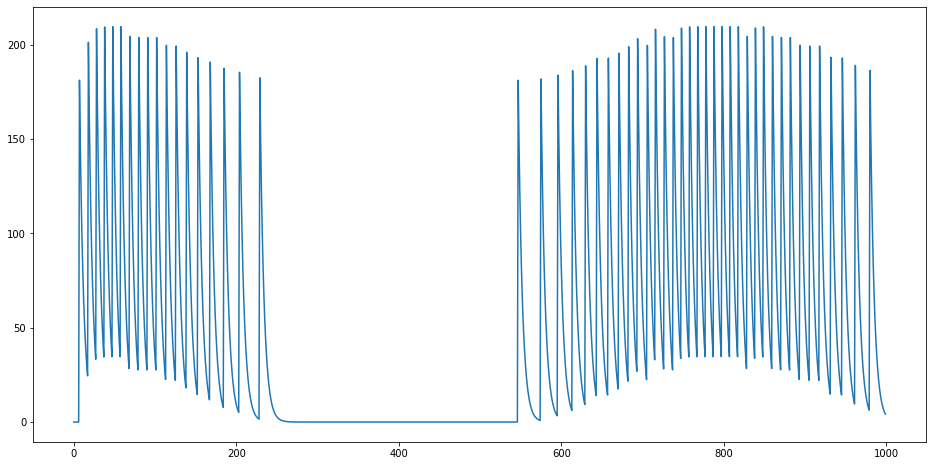

In [12]:
low_pass = nengo.Lowpass(0.005) # Value to time constant dictates the resulting amplitude.
plt.figure(figsize=(16, 8))
plt.plot(low_pass.filt(sim.data[spikes]))

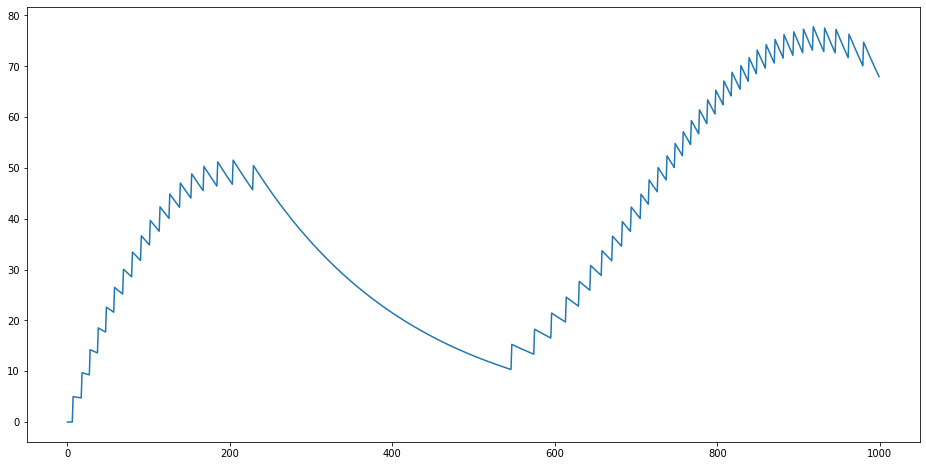

In [13]:
low_pass = nengo.Lowpass(0.2)
plt.figure(figsize=(16, 8))
plt.plot(low_pass.filt(sim.data[spikes]))

In [14]:
#conn.pre, conn.post
#print(sim.data[conn].weights)
#print(dir(sim.data[conn]))
#print(dir(conn))


# with nengo.Network() as net:
#   conn = nengo.Connection(neuron, neuron)

# with nengo.Simulator(net) as sim:
#   D = sim.data[conn].weights

# Explicit LIF neuron and NEF

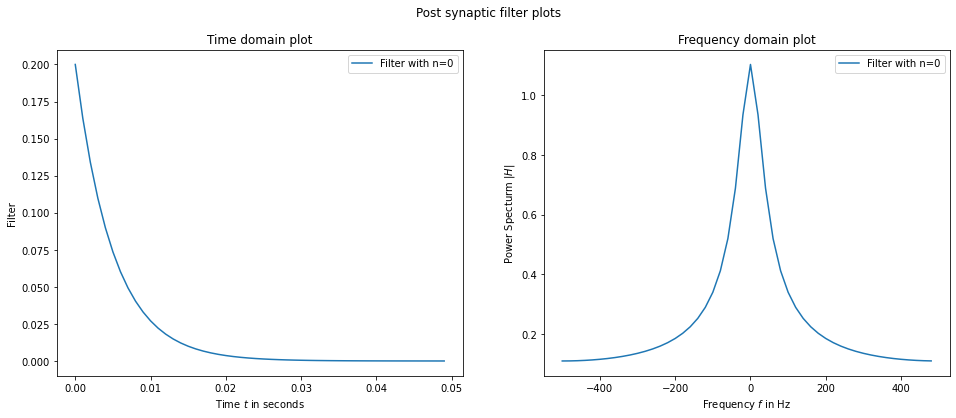

In [15]:
# ✍ <YOUR SOLUTION HERE>
#
def _post_synaptic_filter(t, n, tau):
    return np.exp(-(t/tau))/tau

def get_post_synaptic_filter(n, tau, T=1, dt=1e-3):
    time_seconds = np.arange(0, T, dt)
    ht = []
    for time in time_seconds:
        ht.append(_post_synaptic_filter(time, n, tau)) 
    return time_seconds, np.array(ht)*dt # Scale the signal.
    #return time_seconds, np.array(ht) # Scale the signal.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Post synaptic filter plots")
ns = [0]
T, dt = 0.05, 1e-3
for n in ns:
    time_seconds, ht = get_post_synaptic_filter(n, tau=5e-3, T=T)
    ax1.plot(time_seconds, ht, label="Filter with n=%s" % n)
    ax2.plot(np.fft.fftshift(np.fft.fftfreq(int(np.round(T/dt)), dt)), np.abs(np.fft.fftshift(np.fft.fft(ht))), 
             label="Filter with n=%s" % n)
ax1.set_xlabel("Time $t$ in seconds")
ax1.set_ylabel("Filter")
ax1.set_title("Time domain plot")
ax1.legend()

ax2.set_xlabel("Frequency $f$ in Hz")
ax2.set_ylabel("Power Specturm $|H|$")
ax2.set_title("Frequency domain plot")
ax2.legend()

In [16]:
def _get_slope(J, v, tau_RC):
    return float((J - v))/tau_RC

# Get the spike train output on x(t)
def simulate_spiking_neuron(T, dt, x, tau_RC, tau_ref, e=1):
    """
    Args:
        T (float): The total time of simulation.
        dt (float): Time step for each next point.
        x (numpy.ndarray): The time varying input represented value.
        tau_RC (float): The RC time constant.
        tar_ref (float): The refractory period.
        e (int): The encoding vector.
    """
    # Assumptions.
    v_rest, v_th = 0, 1
    time_points = np.arange(0, T, dt)
    # Size of input stimulus x should match the size of time_points and both of them should have same dt.
    assert time_points.size == x.size 
    spike_times = [] # Stores the times when the neuron spikes.
    v = []
    num_spikes = 0
    flag_threshold = False
    
    # The Jbias and alpha is determined with respect to the Nengo LIF neuron where at x=0 the firing rate
    # is 50Hz and at x=1, the firing rate is 100Hz.
    # Jbias = G^{-1}[40].
    Jbias = 1 / (1 - np.exp((tau_ref - 1/50) / tau_RC))
    # alpha = G^{-1}[a^{max}] - G^{-1}[40]
    alpha = 1 / (1 - np.exp((tau_ref - 1/100) / tau_RC)) - Jbias
    
    # Current Time Step `cts` where x[cts=0] = input signal x's value at time t=0, 
    #                               x[cts+1] = input signal x's value at time t=t+dt,
    #                               x[cts+2] = input signal x's value at time t=t+dt+dt, and so on.. 
    cts = 0 
    current_time = 0
    
    while(cts<int(np.round(T/dt))):
        #Get J for the current time step from the input signal.
        J = alpha*e*x[cts] + Jbias
        
        if cts==0: # First calculation of membrane potential v, therefore assuming the previous v to be v_rest.
            slope = _get_slope(J, v_rest, tau_RC)
            v_curr = v_rest + dt*slope
        else:
            slope = _get_slope(J, v[-1], tau_RC)
            v_curr = v[-1] + dt*slope
        
        if v_curr >= v_th: # If v_current >= v_th at the current_time, the neuron spikes.
            v.append(v_curr)
            num_spikes += 1
            spike_times.append(current_time)
            time_of_spike = current_time
            
            # Set the neuron's state in refractory period.
            while(current_time < time_of_spike + tau_ref):
                current_time += dt
                cts += 1
                v.append(0)
                
        elif v_curr < 0: # If the v_current goes below zero at the current time, reset it to 0
            v.append(0)
        
        else:
            v.append(v_curr)
            
        current_time += dt # update the current time at which the new membrane potential occurs.
        cts += 1
    
    assert num_spikes == len(spike_times)
    # For the last `current_time` which is greater than or equal to 1, 
    #we don't need the last calculated membrane potential, therefore v[:-1]
    #return num_spikes, spike_times, v[:-1]
    return num_spikes, spike_times, v[:]

In [17]:
# _get_spike_lines return spikes with amplitudes 1/dt
def _get_spike_lines(times, spike_times, dt=1e-3):
    spikes = []
    i = 0
    for time in times:
        if i < len(spike_times) and np.allclose(time, spike_times[i]):
            spikes.append(int(np.round(1/dt)))
            i += 1
        else:
            spikes.append(int(np.round(0/dt)))
    
    return spikes
  
def plot_spikes(T, dt, spike_times):
    times = np.arange(0, T, dt)
    spikes = _get_spike_lines(times, spike_times, dt)
    assert int(np.round(np.sum(spikes)*dt)) == len(spike_times)
    fig, ax = plt.subplots(figsize=(6,4))
    #fig.suptitle("Spike Train for constant input x = %s" % x)
    ax.plot(times, spikes)
    ax.set_xlabel("Time $t$ in seconds")
    ax.set_ylabel("Spike")

## Get the filter, input Cos signal, and obtain spikes

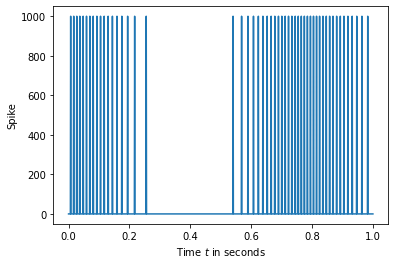

In [18]:
time_seconds, ht = get_post_synaptic_filter(n=0, tau=5e-3, T=1)
cos_signal = np.cos(8 * np.arange(0.001, 1.001, 1e-3))
_, pn_spike_times, voltage = simulate_spiking_neuron(1, 1e-3, cos_signal, 20e-3, 2e-3, e=1)

plot_spikes(1, 1e-3, pn_spike_times)

## Get the Activity Matrix from Spikes

In [19]:
times = np.arange(0, 1, 1e-3)
A = np.zeros((times.size, 1))
A[:, 0] = _get_spike_lines(times, pn_spike_times)
A = A.T # Change the shape of A as num_neurons x num_input_samples

# Decode Spikes -> Filter Decoded Spikes : Wrong Output

## Get the Decoder from Spike Activity Matrix

In [20]:
D = np.linalg.inv(A.dot(A.T)).dot(A).dot(cos_signal.reshape(1000, 1)).T

### Decoded the spikes to get the Cos signal and then filter it => No appropriate reconstruction 

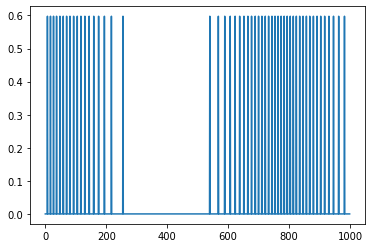

In [21]:
cos_signal_hat = D.dot(A)
plt.plot(cos_signal_hat[0])

### Filter the decoded Cos signal output using Synaptic filter: Filtered Cos signal has lower amplitude than 1

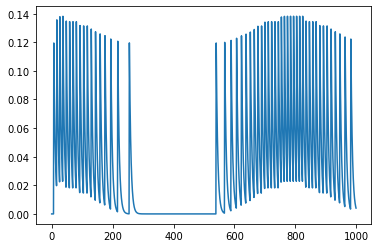

In [22]:
cos_signal_hat_filtered = np.zeros((1, times.size))

for ii in range(1): # Number of neurons n = 2.
    spikes = cos_signal_hat[ii]
    for jj in range(0, spikes.size):
        if spikes[jj] > 0: # A spike has occurred here.
            cos_signal_hat_filtered[ii][jj:] = cos_signal_hat_filtered[ii][jj:] + (ht*spikes[jj])[0:1000-jj]

plt.plot(cos_signal_hat_filtered[0])          

# Filter Spikes -> Decode Filtered Spike: Appropriate Reconstruction of Cos

### Get the filtered spikes

In [23]:
A_filtered = np.zeros((1, times.size))

for ii in range(1): # Number of neurons n = 1.
    spikes = A[ii]
    for jj in range(0, spikes.size):
        if spikes[jj] > 0: # A spike has occurred here.
            A_filtered[ii][jj:] = A_filtered[ii][jj:] + (ht*spikes[jj])[0:1000-jj]

### Decode the filtered spikes

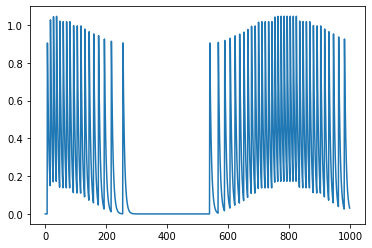

In [24]:
D = np.linalg.inv(A_filtered.dot(A_filtered.T)).dot(A_filtered).dot(cos_signal.reshape(1000, 1)).T
cos_signal_hat_filtered = D.dot(A_filtered)
plt.plot(cos_signal_hat_filtered[0])

(0.0, 1.0)

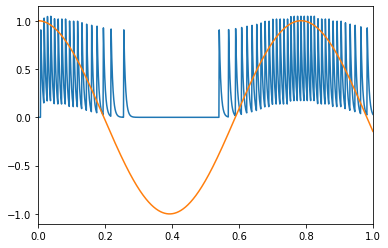

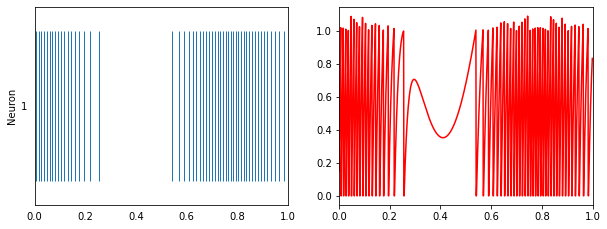

In [25]:
from nengo.utils.matplotlib import rasterplot
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(times, cos_signal_hat_filtered[0])
plt.plot(times, cos_signal)
plt.xlim(0, 1)

# Plot the spiking output of the ensemble
plt.figure(figsize=(10, 8))
plt.subplot(221)
rasterplot(times, A.T)
plt.ylabel("Neuron")
plt.xlim(0, 1)

# Plot the soma voltages of the neurons
plt.subplot(222)
plt.plot(times, voltage, "r")
plt.xlim(0, 1)